<p style="font-size:32px;text-align:center"> <b>Social Network Graph Link Prediction - Facebook Challenge</b> </p>

Now, we have our dataset with us which is split into two parts train and test. Also, in both sets, we have 0 labeled and 1 labeled data points consisting of pairs of vertices. Now, we can't perform machine learning on this. We need to featurize these data points. We will have to create feature vectors and their associated lables corresponding to each of the data points. So, given pairs of vertices, we will try to come up with sensible and graph-thoretic/based features in this section of this project. Features maybe numerical, binary or categorical in nature. Once, we are done doing it, we could do similar for test set and see if we can predict our labels accurately or not.

# 4. Importing Libraries and Packages

Just importing few packages, that we will be using in this section:

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 5. Reading Data

In [ ]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


You can see that we are making use of ```NetworkX``` library and for manipulating our graph based dataset. Also, we  are making use of dataset, we observed at the end of the EDA section. Later we are printing some basic stats like:number of nodes/users are 1.78M who have 7.55M edges between them. Also, the average in-degrees and out-degrees are 4.23.

Let's look at couple of very simple featurizations:

# 6. Similarity Measures

One who follows is known as a Follower while the one being followed is called a Followee.

## 6.1 Jaccard Distance

Say, there are two users $u_1$ and $u_2$. Now, consider, $u_1$ has $u_3$, $u_4$ and $u_5$ as followers. Likewise, $u_2$ has $u_3$, $u_4$ and $u_6$ as followers. All cool! Now, representing this information with sets:

$$X = \{u_3, u_4, u_5\}\longrightarrow u_1$$ 

And Likewise, $$Y = \{u_3, u_4,u_6\}\longrightarrow u_2$$ 

Here, we are referring both these sets as $X$ and $Y$. Now, given any two sets $X$ and $Y$, Jaccard Distance is ratio of size of $X \cap Y$ and $X \cup Y$ i.e. 

\begin{equation}
J = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

Now, this explains that due to their interests being similar as having lot of common followers or they might belong to a common group of friends, there is a high chance that user $u_1$ might wanna follow $u_2$ or vice versa. Because of this overlap, it looks sensible to recommend one user to the other. In our case, Jaccard Distance will be: $$J = \frac{2}{4}$$

The larger the jaccard index, the higher is the probability that there exists an edge between $u_1$ and $u_2$. Jaccard Index isn't only used in graph theory but also in set theory where it's used to detect how much similar two sets are. Just the way, we are doing it for followers set; similarly it can be done for followee set. So, given any two users, I can obtain their followers and followee and later can calculate jaccard index in both cases. And this is what I've done in following code snippets:

Refer: http://www.statisticshowto.com/jaccard-index/

In [ ]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

```jaccard_for_followees``` is a function which takes two vertices ```a``` and ```b``` as input and returns out the ```sim``` or similarity score using the same formula we studied above.

In [ ]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [ ]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


We can see how for vertex no. 273084 and 1505602, there is no similarity at all. Here, we first obtained followees for these sets and later calculated jaccard similarity/index. Let's create same for followers for as well:

In [ ]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

```jaccard_for_followers``` is a function which takes two vertices ```a``` and ```b``` as input and returns out the ```sim``` or similarity score using the same formula we studied above.

In [ ]:
print(jaccard_for_followers(273084,470294))

0


In [ ]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


Likewise, we saw above, we can see how for vertex no. 669354 and 1635354, there is no similarity at all. Here, we first obtained followers for these sets and later calculated jaccard similarity/index. 

## 6.2 Cosine Distance (Otsuka-Ochiai Coefficient)

Many of us are familiar with how to calculate cosine similarity between two vectors. Cosine Distance is a simple variant of this which works on sets. It says, imagine if I've two sets $X$ and $Y$, we can define the cosine distance as follows:

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{\sqrt{|X|\times|Y|}} 
\end{equation}



Refer: https://en.wikipedia.org/wiki/Cosine_similarity#Otsuka-Ochiai_coefficient

If there is a larger overlap between sets $X$ and $Y$, then this ratio will be larger. It's just as same as the Jaccard Index only difference being that the denominator is changed. Here, we are using square root of product of number of elements in $X$ and $Y$ respectivley instead of union of both sets.

And just like we did previously, we will have one function for followers and other for followees:

In [ ]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

```cosine_for_followees``` is a function which takes two vertices ```a``` and ```b``` as input and returns out the ```sim``` or similarity score using the same formula we studied above.

In [ ]:
print(cosine_for_followees(273084,1505602))

0.0


In [ ]:
print(cosine_for_followees(273084,1635354))

0


We can see how for vertex no. 273084, no. 1505602 and no. 1635354 there is no similarity at all. Here, we first obtained followees for these sets and later calculated cosine distance. Let's create same for followers for as well:

In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

```cosine_for_followers``` is a function which takes two vertices ```a``` and ```b``` as input and returns out the ```sim``` or similarity score using the same formula we studied above.

In [ ]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [ ]:
print(cosine_for_followers(669354,1635354))

0


Likewise, we saw above, we can see how for vertex no. 669354 and 1635354, there is no similarity at all. Also, for vertex no. 2 and 470294 the similarity comes out to be 0.02. and Here, we first obtained followers for these sets and later calculated cosine distance.

## 7. Ranking Measures

PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results. PageRank was named after Larry Page, one of the founders of Google. PageRank is a way of measuring the importance of website pages. According to Google:

>PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

Currently, PageRank is not the only algorithm used by Google to order search results, but it is the first algorithm that was used by the company, and it is the best known.

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

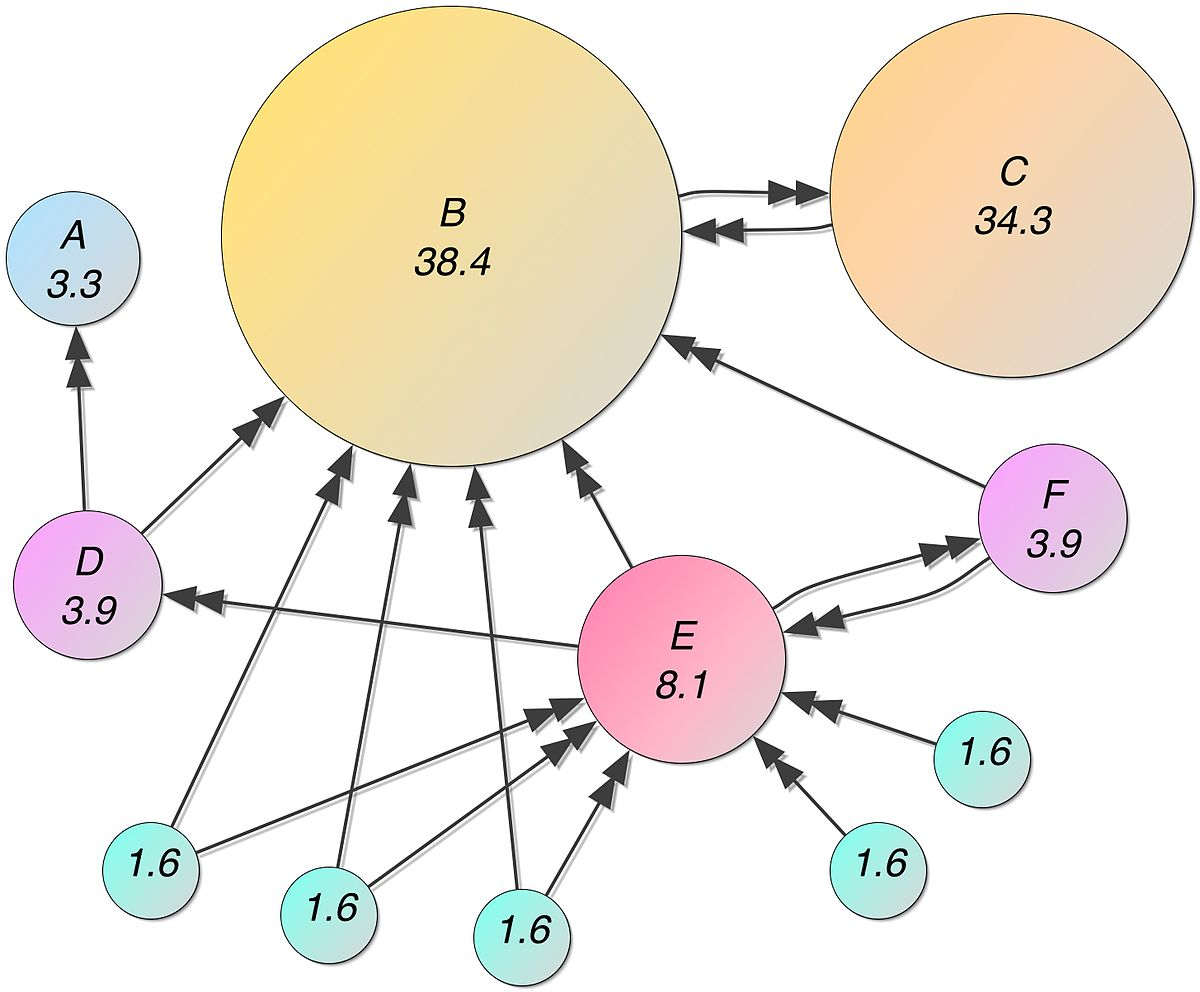

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>


Refer: https://en.wikipedia.org/wiki/PageRank

## 7.1 Page Ranking

Given, a directed graph, pagerank algorithm gives each user a score that represents how important this vertex is in this directed graph. Now how Pagerank helps us when it was originally created for ranking web-pages? See, when we are representing our users with the help of nodes in our graph, if using the pagerank algorithm a certain node/user gets a high score, it indicates that many other important users are linked/connected to this user which eventually makes its score high. Hence, there is a high likelihood of this user getting recommended/suggested to other users due to this score. Pagerank can tell us about the relative score/importance of each of the vertices in the graph.

Let's understand it with this easy example: Bill Gates is followed by Mark Zuckerberg, Warren Buffet i.e. big players and he is also followed by random small people like by me and you. The fact that lots of people including some big names are following Bill Gates, he must be an important person. And hence, he has a significantly higher chance of being followed by a random. It's really less probable that a random user would follow me and you; but chances of a random person following him are quite high.

We can implement pagerank from scratch, but we need not to. We will use ```NetworkX``` for the same:


Refer: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

In [ ]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

Here, we are just using our ```train_graph``` and implmenting pagerank with ```NetworkX``` package. Also, we have set our hyperparameter ```alpha``` denoting *Damping Parameter* to 0.85 which is default value.

In [ ]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


Here, we are obtaining minimum, maximum and mean page rank value given to each vertex. These values are quite small as you can see; recall as we discussed that pagerank computes probability values to indicate that whether a user will land up on a given webpage. Due to this reason, Google uses a variant of it which computes probability values on a logarithmic scale.

In [ ]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


For all those vertices, which aren't part of ```train_graph```, we are assigning mean pagerank value. Also, as per structure of our dataset, we are getting two feature, pagerank for our source vertices and destination vertices.

# 8. Other Graph Features

## 8.1 Shortest Path

Getting Shortest path between two nodes-if nodes have direct path/edge i.e directly/trivially connected then we will remove that edge and thereafter will calculate shortest path. And if there is no edge between two nodes, we will assign them a value of -1.

For two vertices $u_i$ and $u_j$, if the length of the shortest path is low, there is a higher chance that $u_i$ could be following $u_j$ or vice-versa. Hence, shortest path is a very good metric which measures how far two vertices/nodes are.

In [ ]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

Once again, we are making use of ```NetworkX``` package to calculate shortest path length between any two vertices source being ```a``` and destination being ```b```. We are making use of our ```train_graph```.

In [ ]:
#testing
compute_shortest_path_length(77697, 826021)

10

It's pretty evident that the shortest path between nodes 77697 and 826021 is 10. So, there is less chance of either of these users getting recommended to each other.

In [ ]:
#testing
compute_shortest_path_length(669354,1635354)

-1

We can see how, there is no edge between nodes 669354 and 1635354; due to which we have assigned it a length -1.

## 8.2 Checking For Same Weakly Connected Component (Community)

A Strongly Connected Component is a sub-graph contains some vertices/nodes where there is a path from every node to every other node. To borrow an example from Wikipedia:

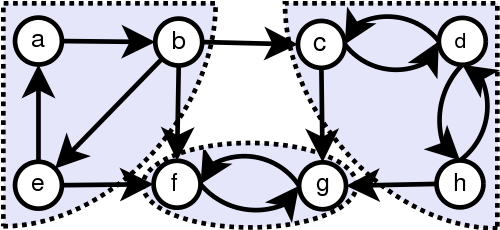


There are three Strongly Connected Components: $[abe]$, $[fg]$, and $[cdh]$. It's easy to see how you can get from $a \rightarrow b$, $b \rightarrow e$, $e \rightarrow a$. You can also get from $b$ to $a$, via $e$, and so forth. But $f$ isn't included, since there's no path from $f$ back to $a$ (or $b$ or $c$).

A weakly connected component is one in which all components are connected by some path, ignoring direction. So this entire graph would be a weakly connected component.

You might wonder, why do we even care about weakly connected components? Reason being, that people showing similar interests, being from same college or workplace, people from same regions, form communities represented aptly by weakly connected components. In graph theory, weakly connected components can be thought of as a community of people sharing a common trait amongst themselves.

Now, if two users $u_i$ and $u_j$, belong to the same weakly connected component, there is high chance of them having similar interests, same college/workplace, same mutual friends etc, hence it seems okay to recommend these individuals to each other as recommendations.

In [ ]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

Using, ```nx.weakly_connected_components```, we can achieve all the weakly connected edges from the dataset ```train_graph```. Thereafter, for two vertices ```a``` and ```b```, we are using ```belongs_to_same_wcc``` function to check whether both of the vertices belong to the same weakly connected component or not. This will be a binary feature, that will throw out 0 and 1 respectively for "not belonging" and "belonging" to same community.

In [ ]:
belongs_to_same_wcc(861, 1659750)

0

Here, we are just pushing in two vertices/nodes 861 and 1659750, and our function returns 0 implying that both nodes are not part of the same community.

In [ ]:
belongs_to_same_wcc(669354,1635354)

0

Likewise, what we saw above, both these nodes are not part of the same community.

## 8.3 Adamic/Adar Index

The Adamic/Adar index is a measure introduced in 2003 by Lada Adamic and Eytan Adar to predict links in a social network, according to the amount of shared links between two nodes. It is defined as the sum of the inverse logarithmic degree centrality of the neighbours shared by the two nodes.

Hence, simply, Adamic/Adar measures can be defined as inverted sum of degrees of common neighbours for given two vertices.


$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

where $N(u)$ is the set of nodes adjacent to $u$. Such definition is based on the concept that common elements with very large neighbourhoods are lesser significant when predicting a connection between two nodes compared with elements shared between a small number of nodes.

Keeping this idea in mind, imagine, there are two users $u_i$ and $u_j$. They have links from and towards a set of nodes/users. Among these set of vertices, few would be common amongst both. Now, for any such vertex, which is common to both $u_i$ and $u_j$, we will compute it's neighborhood. If its neighborhood is large, there is less chance of $u_i$ and $u_j$ being known to each other; hence recommendation/suggestion doesn't feel right. On the other hand, if the neighborhood comes out to be small, it's highly likely that both $u_i$ and $u_j$ must be in a close group; hence recommendation/suggestion looks like a good choice. Hence, if $N(u)$ is large, then resulting Adar Index will be low and vice-versa. You can also understand this by taking an example like: considering a person from Canada and India both listening to the music of the Weeknd. As Weeknd itself has a large neighborhood, it's very less likely that they would know each other.

Note, Adar Index was originally defined for undirected graphs; but we will make use of it by using ```successors``` method from ```NetworkX``` package. Get the neighborhood from all the successor intersections and for each vertex and in intersection get the number of ```predecessors```. This is simple feature engineering we did to work with a directed graph.

In [ ]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

We have just slightly changed the Adar Index for our use-case.

In [ ]:
calc_adar_in(1,189226)

0

We can see, the value coming out of function ```calc_adar_in``` is low, hence it signifies that both nodes/users 1 and 189226 have large neighborhoods and so might not know each other.

In [ ]:
calc_adar_in(669354,1635354)

0

Similar observations as above, this ain't gonna be a good recommendation/suggestion.

## 8.4 Does the Person Follow Back?

What we are trying to predict? Imagine, if somebody gives us a pair of vertices $(a, b)$, we want to predict is there an edge or not? Here, we are saying, is there an edge from $b$ to $a$ already? If the answer is yes, there is  very high likelihood that there could be an edge from $a$ to $b$. You can get it this way, if $b$ is a friend of $a$ and is following $a$, then $a$ can be a friend of $b$ and could be following $b$. Very simple, yet very powerful idea especially in cases like Instagram.

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

```follows_back``` function takes two vertices $a$ and $b$ as input and throws 1 out if there is an edge from $b$ to $a$ and if there is not returns 0.

In [ ]:
follows_back(1,189226)

1

It's clear that, node/user 189226 follows back node/user 1.

In [ ]:
follows_back(669354,1635354)

0

Carrying the same idea, the ouput of the above cell shows that node/user 1635354 doesn't follow back node/user 669354.

## 8.5 Katz Centrality

In graph theory, the Katz centrality of a node is a measure of centrality in a network. It was introduced by Leo Katz in 1953 and is used to measure the relative degree of influence of an actor (or node) within a social network. Unlike typical centrality measures which consider only the shortest path (the geodesic) between a pair of actors, Katz centrality measures influence by taking into account the total number of walks between a pair of actors.

It is similar to Google's PageRank and to the eigenvector centrality.

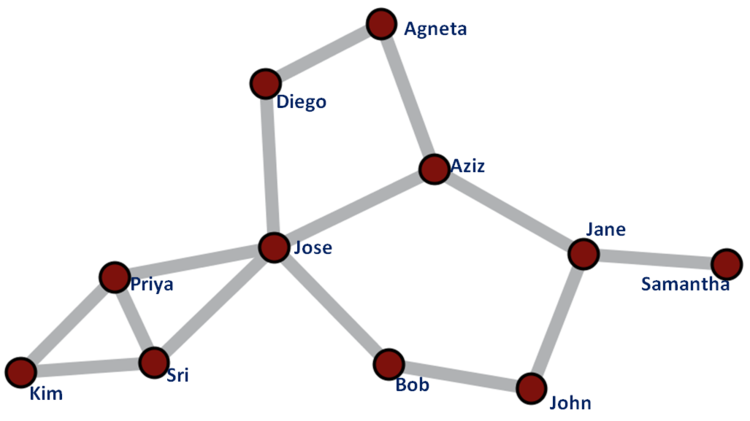

Refer: https://en.wikipedia.org/wiki/Katz_centrality

Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$

where $A$ is the adjacency matrix of the graph $G$ with eigenvalues $\lambda$. The parameter $\beta$ controls the initial centrality and $\alpha < \frac{1}{\lambda_{max}}$.

Refer: https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [ ]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

Once again, we are making use of ```NetworkX``` package and available method ```katz.katz_centrality``` in it. We have also setted up values of parameters ```alpha``` and ```beta```.

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


Here, we are just printing out the minimum, maximum and mean value of Katz Centrality for all the nodes in our dataset.

In [ ]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## 8.6 HITS Score

In the earlier 1990's, Yahoo and AOL were some of the popular search engines before Google came into existence. These kinds of search engines used something called directory structure where all the links were divided into these sub-directories. Say, directory for news would have links to webpages concerned to news outlets like Washington Post, CNN, Fox News etc. Directory for pets would have links to webpages concerned to pet-based websites. This was quite different to what we experience today at Google.

Now, in this world, there were two types of pages: Hubs and Authorities. Hub can be thought of as a site having lots of outlinks. yahoo.com and aol.com had lots of pages going away from them, hence they can be considered as hubs. Hubs because people come upto you to start their internet journey. Outlinks is just another term for out-degree; which we have been talking about the whole time. The other term is Authority. Say, pages like bbc.com and mit.edu; they might not lead you to many other pages, but a lot of other pages lead you to them leading to a huge number of inlinks. Such sites are referred as Authority. Lots of people think, that you have good quality information, hence you're authoritative in nature. And just like previously, Inlinks is just another name for in-degree.

The HITS algorithm computes two numbers for a node-Hubs and Authorities. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

It is an iterative algorithm by nature. Initially, values of both hub and authority are set to 1. And thereafter, for updating authority, for any node/user, $p$, authority is equal to sum of all the hub scores/values of all the nodes connected to $p$. Say, yahoo.com is linking to cnn.com, then the authority score of cnn.com would be higher as yahoo.com's hub score would be larger. As a more popular page is linking to me, my authority score would be larger.

Likewise, for any node/user, $p$, hub is equal to sum of all the authority scores/values of all the nodes linking to $p$. So, for yahoo.com, it's hub score would be equal to the sum of the authority values of all the webpages linking to it.

Now, as we studied, that it's an iterative algorithm, the values of hub and authority scores in this manner gonna go to reach $\infty$. Hence, in order to stop these values from reaching there, once we have updated hub and authority score of each node/vertex/user, we normalize it.

We will keep repeating these three steps iteratively, and eventually the values of hub and authority scores would converge. And this can be proven mathematically. So, we keep running the iterations, till the time these scores don't change much.

Although, it is widely used in web search, but it works fine in our case well. For a node, whose authority value is large, we can deduce that this node is probably a celebrity as lots of people are following it. Likewise, for a node, whose hub value is large, we can think of it as a person who likes to follow a lot of people.

Refer: https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

We are implementing ```hits``` using our ```NetworkX``` package. Also, we have setted up respective parameters for number of iterations, error tolerance to check convergence, starting value of each node and normalization.

In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


And here we have minimum, maximum and average hubs values for all the nodes/users in our graphs.

# 9. Featurization

## 9.1 Reading a Sample of Data from both Train and Test

As we know that we have quite a big dataset, we can read few random lines from it and can perform some basic statistics:

In [ ]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

Here we are just loading our train set, and sampling few data points for faster loading.

In [ ]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

Likewise, we are simply loading our test file, and sampling some of the data points.

In [ ]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


The output explains how many rows are present in train and test file, and how many rows we are going to elliminate from these files.

In [ ]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,832016,1543415,1


You can see, that our final train matrix contains about 100k rows and has 3 columns signifying source and destination nodes and whether an edge exists between them or not.

In [ ]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,483294,1255532,1


Similar to what we saw above, we have around 50k rows in our final test matrix and 3 columns signifying source and destination nodes and whether an edge exists between them or not.

## 9.2 Adding a Set of Features

**We will create each of these features for both train and test data points:**

<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

All the features we defined and explained before, now we are just adding them up and storing in our dataset.

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccard followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

```compute_features_stage1``` function takes ```df_final``` as input and returns number of followers, followees of source and destination; and intersection or common followers and followees between source and destination.

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

All the features we defined and explained in last cell, now we are just adding them up and storing in our dataset.

## 9.3 Adding New Set of Features

**We will create each of these features for both train and test data points:**

<ol>
<li>Adar index</li>
<li>Is following back?</li>
<li>Belongs to same Weakly Connected Components</li>
<li>Shortest Path between Source and Destination</li>
</ol>

All the features we defined and explained before, now we are just adding them up and storing in our dataset.

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

## 9.4 Adding New Set of Features

**We will create each of these features for both train and test data points:**

<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of Source.</li>
<li>Page Ranking of Destination.</li>
<li>katz of Source.</li>
<li>katz of Destination.</li>
<li>hubs of Source.</li>
<li>hubs of Destination.</li>
<li>authorities of Source.</li>
<li>authorities of Destination.</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other.

> Refer: Graph-based Features for Supervised Link Prediction by William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

Here, $X$ is a set of vertices linking into a vertex $u_I$. On comparing, the celebrity and a normal person's score, the latter comes out to be quite large than the former. This is referred as In-weight feature. Same weighted feature can be computed for out-links and hence called out-weight feature. And also, $X$ is a set of vertices linking out from a vertex $u_i$ in this case. 

In our problem, as it is a directed graph so we're calculating Weighted in and Weighted out separately. As you can see above, we have created different weight based features. Hence, for every vertex $u_i$, we have 6 features.

In [ ]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|████████████████████████████████████████████████████████████████████| 1780722/1780722 [00:11<00:00, 152682.24it/s]


In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

Here, all the features we defined and explained before, now we are just adding them up and storing in our dataset.

## 9.5 Adding New Set of Features

**We will create each of these features for both train and test data points:**
<ol>
<li>SVD features for both source and destination.</li>
</ol>

Matrix Factorization can also be used for feature engineering. Now, given graph data, how we can make use of SVD-which is a popular matrix factorization method. Now, consider you have a graph $G$ containing pairs of vertices $u_i$ and $u_j$ such that $u_i \rightarrow u_j$ or there's an edge from $u_i$ to $u_j$. There is a concept in graph theory called as Adjacency Matrix which basically represents all of the information present in graph in the matrix form. Say, we have $A$ as an adjacency matrix of our graph $G$. We have a very simple directed graph; adjacency matrix changes from graph to graph. Our graph $G$ has around 1.78M users in our training data, hence this matrix i.e. $A$ will have dimensions 1.78M $\times$ 1.78M. Also, each cell in our adjacency matrix can be represented by $A_{ij}$. Now, as $G$ is a directed graph, $A_{ij} = 1$ if $u_i \rightarrow u_j$ or if there exists a directed edge from $u_i$ to $u_j$. Also, it's going to be 0 otherwise. Hence, in our case, this adjacency matrix is a binary matrix. There are other variants of adjacency matrix for undirected graphs, but we are not concerned about them here. Let's focus only on our problem.

Although, the challenge here is that, we are gonna have a very very large and sparse matrix as most of the cells or $A_{ij}$'s are gonna be 0. Reason being, that for most of the vertices, there are only a few edges present.

Now, given this matrix $A$, if I apply SVD, we are gonna get this: $$A = U \Sigma V^T$$ Here, $U$, $\Sigma$ and $V^T$ are three matrices. In some books, $\Sigma$ is represented by $S$. In this equation, considering we have taken number of components i.e. ```k = 6``` in following code snippet:

$$A = 1.78M \times 1.78M$$ 

where $A$ is a binary sparse matrix. Imagine, if I decompose it in this way:

$$U = 1.78M \times 6$$

$$\Sigma or S = 6 \times 6$$

$$V^T = 6 \times 1.78M$$

This arrangement complies with the rules of Matrix Multiplication. Also, $U$ and $V^T$ are referred as left singular matrix and right singular matrix respectively. In $U$, I have a 6-dimensional vector representation of any vertex $U_i$. Likewise, in $V^T$, we have 6 rows and 1.78M columns. Hence, $i$th column of $V^T$ is a 6-dimensional vector representation. These two vectors are two representations of my graph vertex $i$. Now, both of these vectors can be used as feature vectors for the $i$th vertex.

Recall, in our dataset, we have a pair of vertices, and we'd want to predict whether there is an edge between them or not. So, if for one vertex, there are two 6-dimensional vectors, hence for a pair will be four 6-dimensional vectors. So, for a pair of vertices, we get a 24-dimensional vector of features.

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
#for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

Here, we are using our ```NetworkX``` package, to implement adjacency matrix over our ```train_graph```.

In [ ]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


Here, we are decomposing our adjacency matrix into three matrices using 6 components.

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

Here we are just adding and storing SVD features into our dataset. You can clearly see that there are 6 dimensional feature vectors each for source and destination in pair of vertices.

So, as of now, we have prepared and stored the data and we are ready to get predictions from machine learning models. Please, check the Facebook Models.ipynb notebook.